In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.utils.data import download_file

# CLEAN

In [2]:
dirname = "/home/mjybarth/projects/rrg-lplevass/data/misha_dsharp_data/"
fname = dirname + "HD143006_continuum.fits"
hdul = fits.open(fname)
hdu = hdul[0]
clean_img = np.squeeze(hdu.data)
header = hdu.header
hdul.close()

In [3]:
# get the number of pixels in each direction
nx = header["NAXIS1"]
ny = header["NAXIS2"]
# RA coordinates
CDELT1 = 3600 * header["CDELT1"]  # Convert from units of degrees to arcsec

# DEC coordinates
CDELT2 = 3600 * header["CDELT2"]  # [arcsec]

# calculate the RA and DEC pixel centers
RA = (np.arange(nx) - nx / 2) * CDELT1  # [arcsec]
DEC = (np.arange(ny) - ny / 2) * CDELT2  # [arcsec]

# matplotlib imshow extent needs to include extra half-pixels.
ext = (
    RA[0] - CDELT1 / 2,
    RA[-1] + CDELT1 / 2,
    DEC[0] - CDELT2 / 2,
    DEC[-1] + CDELT2 / 2,
)  # [arcsec]

Text(0, 0.5, '$\\Delta \\delta$ [${}^{\\prime\\prime}$]')

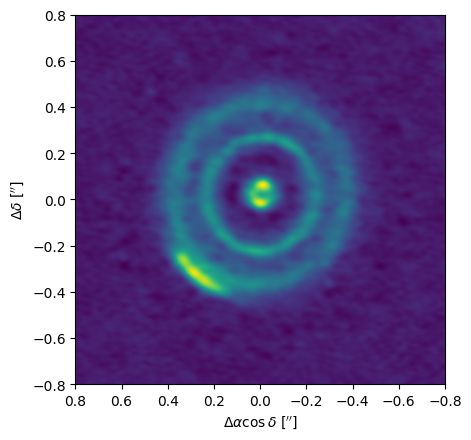

In [4]:
plt.imshow(clean_img, origin="lower", extent=ext)
# zooming in a little to focus on the disk
r = 0.8
plt.xlim(left=r, right=-r)
plt.ylim(top=r, bottom=-r)
# axis labels
plt.xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
plt.ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")

# MPoL

In [5]:
# load extracted visibilities from npz file
fname = dirname + "HD143006_continuum.npz"
d = np.load(fname)
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]

Text(0.5, 1.0, 'Baselines')

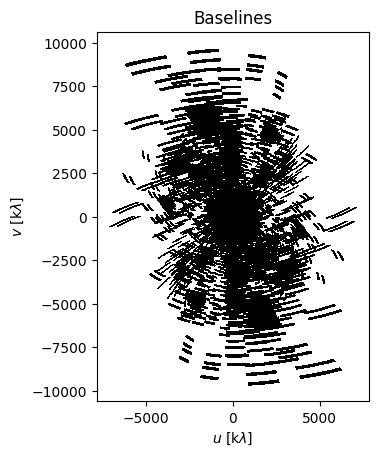

In [6]:
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=0.5, rasterized=True, linewidths=0.0, c="k")
ax.scatter(-uu, -vv, s=0.5, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
ax.set_aspect("equal")
ax.set_title("Baselines")

In [7]:
cell_size = np.abs(header["CDELT1"] * 3600)  # [arcsec]
print("cell_size is {:.4f} arcseconds".format(cell_size))

cell_size is 0.0030 arcseconds


In [ ]:
from mpol import gridding

imager = gridding.DirtyImager.from_image_properties(
    cell_size=cell_size,
    npix=512,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,  # separating the real and imaginary values of our data
    data_im=data.imag,
)

In [ ]:
def image_and_plot(weighting, robust=None):

    img, beam = imager.get_dirty_image(
        weighting=weighting, robust=robust, unit="Jy/arcsec^2"
    )

    kw = {"origin": "lower", "extent": imager.coords.img_ext}
    fig, ax = plt.subplots(ncols=1)
    im = ax.imshow(np.squeeze(img), **kw)
    cbar = plt.colorbar(im)
    cbar.set_label(r"$\mathrm{Jy}/\mathrm{arcsec}^2$")

    title = weighting
    if robust is not None:
        title += " r={:.1f}".format(robust)
    ax.set_title(title)
    ax.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    ax.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
    r = 0.7
    plt.xlim(left=r, right=-r)
    plt.ylim(bottom=-r, top=r)

    return np.squeeze(img)

In [ ]:
_ = image_and_plot(weighting="uniform")

In [ ]:
_ = image_and_plot(weighting="natural")

In [ ]:
_ = image_and_plot(weighting="briggs", robust=-1.0)

In [ ]:
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0, unit="Jy/arcsec^2")

In [ ]:
averager = gridding.DataAverager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=data.real,
    data_im=data.imag,
)
dataset = (
    averager.to_pytorch_dataset()
) 

In [ ]:
from mpol.precomposed import SimpleNet

model = SimpleNet(coords=coords, nchan=averager.nchan)

In [ ]:
# convert the dirty image into a tensor
dirty_image = torch.tensor(img.copy())

# initialize an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)
loss_fn = torch.nn.MSELoss()  # creating the MSEloss function from Pytorch

In [ ]:
for iteration in range(500):

    optimizer.zero_grad()

    model()  # get the predicted model
    sky_cube = model.icube.sky_cube

    loss = loss_fn(sky_cube, dirty_image)  # calculate the loss

    loss.backward()  # calculate gradients of parameters
    optimizer.step()  # update the parameters

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5, 4))

ax[0].imshow(
    np.squeeze(dirty_image.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)

ax[1].imshow(
    np.squeeze(model.icube.sky_cube.detach().cpu().numpy()),
    origin="lower",
    interpolation="none",
    extent=model.icube.coords.img_ext,
)

r = 0.75
for a in ax:
    a.set_xlim(left=0.75, right=-0.75)
    a.set_ylim(bottom=-0.75, top=0.75)
    a.axis("off")

ax[0].set_title("Dirty Image")
_ = ax[1].set_title("Pseudo-Dirty Image")

In [ ]:
torch.save(model.state_dict(), "model.pt")

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import os

logs_base_dir = "./logs/"
writer = SummaryWriter(logs_base_dir)
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard